## **8장 성능 최적화**

### 8.3.2 드롭아웃을 이용한 성능 최적화

In [ ]:
# 8-1 라이브러리 호출
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 8-2 데이터셋 내려받기
trainset = torchvision.datasets.FashionMNIST(root='/', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.2MB/s]


Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]


Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.03MB/s]


Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]

Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw



In [ ]:
# 8-3 데이터셋을 메모리로 가져오기
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
# 8-4 데이터셋 분리
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[1].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
1


In [ ]:
# 8-5 이미지 데이터를 출력하기 위한 전처리
def imshow(img, title):
    plt.figure(figsize=(batch_size*4, 4))  # 출력할 개별 이미지의 크기 지정
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))   # 1
    plt.title(title)
    plt.show()

In [ ]:
# 8-6 이미지 데이터 출력 함수
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    # 이미지 크기는 (4, 28, 28, 1(배치 크기, 높이, 너비, 채널))
    img = torchvision.utils.make_grid(images)
    # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 추력
    imshow(img, title=[str(x.item()) for x in labels])
    # imshow 함수 사용함으로써 데이터의 형태 : (채널, 높이, 너비) -> (높이, 너비, 채널)로 변경됨.
    return images, labels

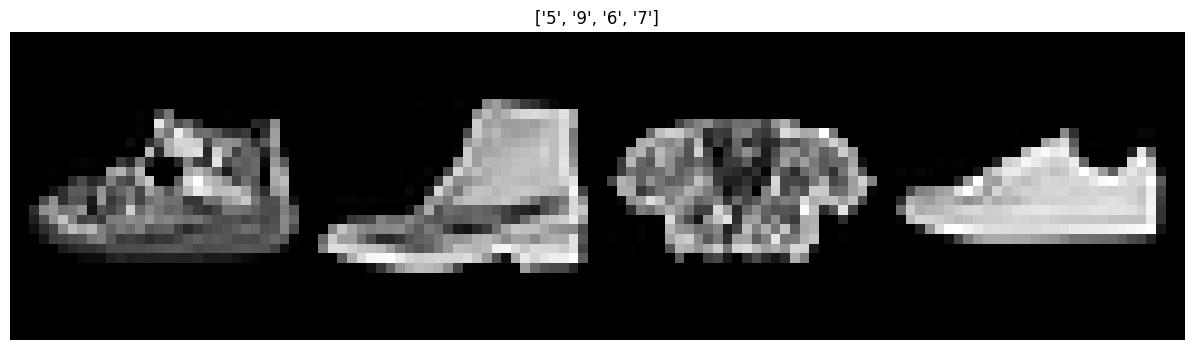

In [ ]:
# 8-7 이미지 출력
images, labels = show_batch_images(trainloader)

In [ ]:
# 8-8 배치 정규화가 적용되지 않은 네트워크
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # (28, 28) 크기의 이미지, 입력은 784(28x28) 크기
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)  # FashionMNIST 클래스 총 10개
        )  # nn.Sequential 사용하여 forward() 함수에서 계층(layer)별로 가독성 있게 코드 구현 가능

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  # nn.Sequential에서 정의한 계층 호출
        return x

In [ ]:
# 8-9 배치 정규화가 포함된 네트워크
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),   # 1
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# 8-10 배치 정규화가 적용되지 않은 모델 선언
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
# 8-11 배치 정규화가 적용된 모델 선언
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
# 8-12 데이터셋 메모리로 불러오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
# 8-13 옵티마이저, 손실 한수 지정
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

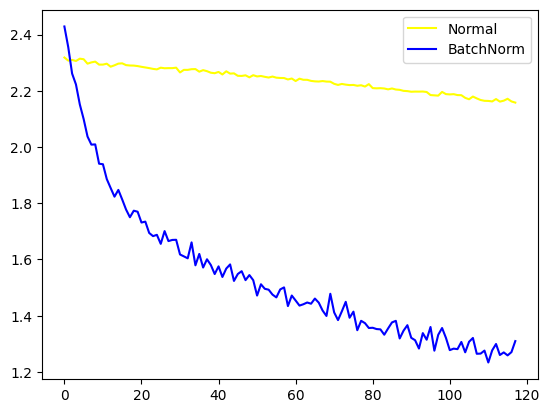

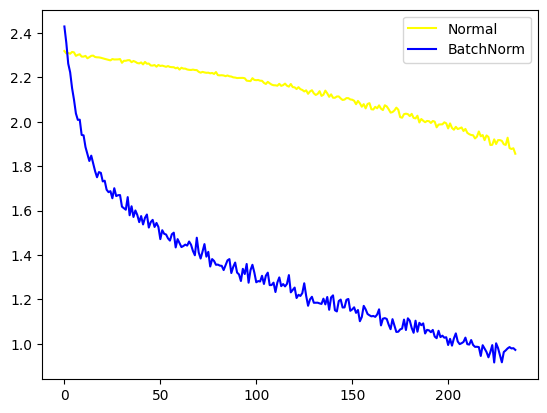

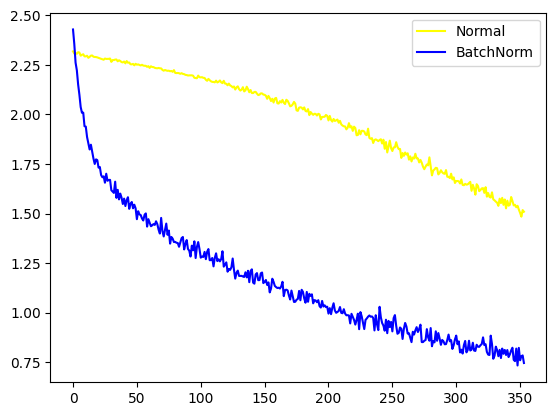

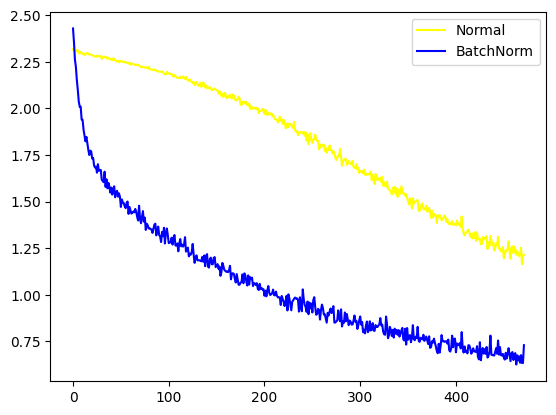

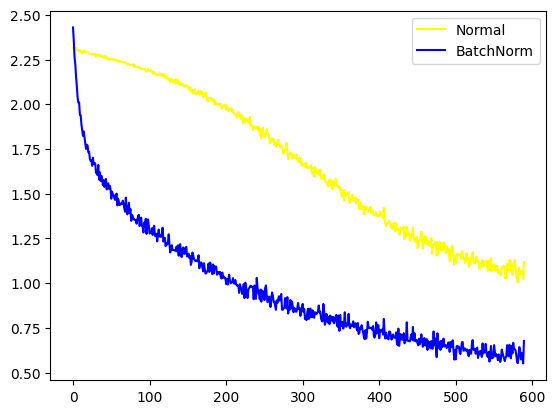

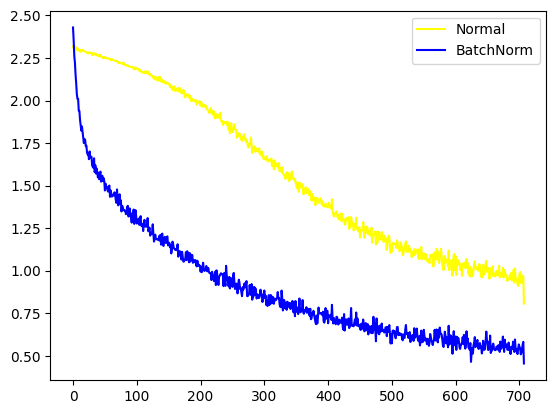

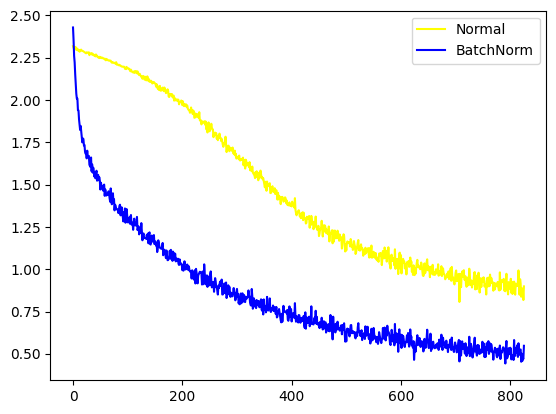

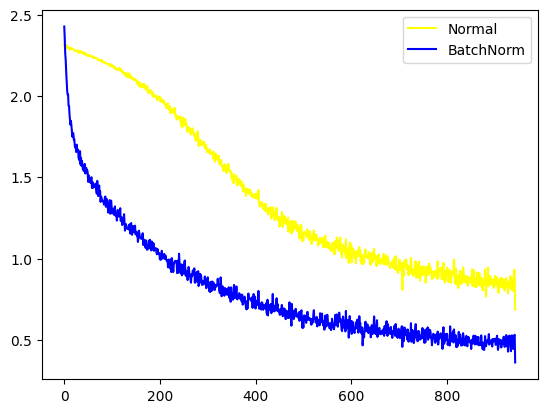

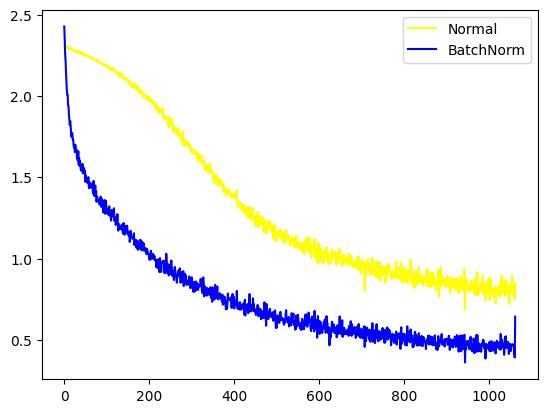

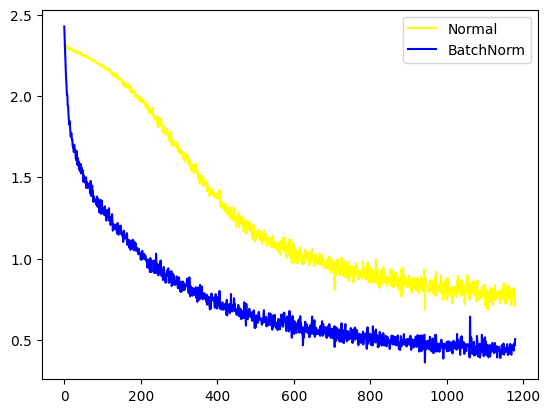

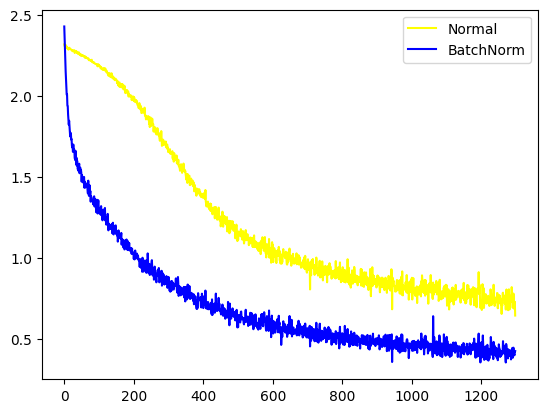

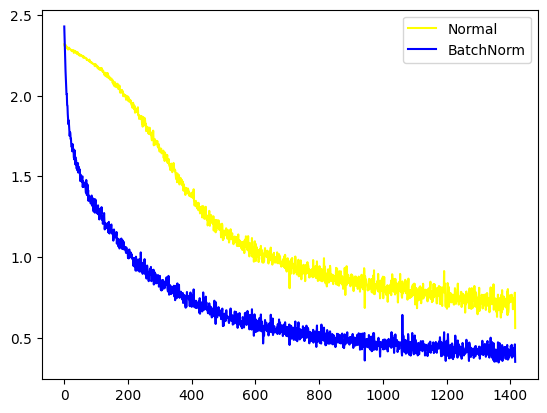

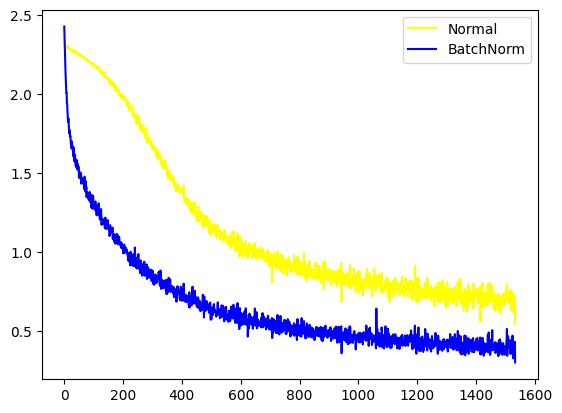

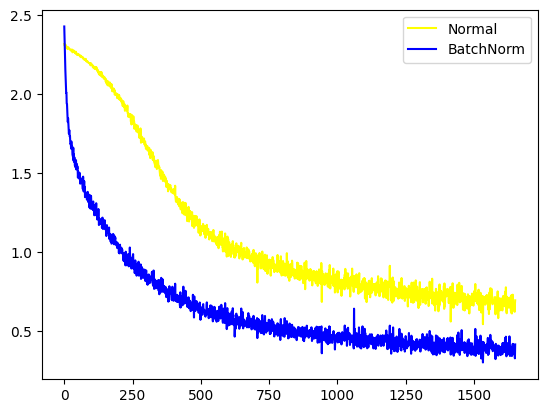

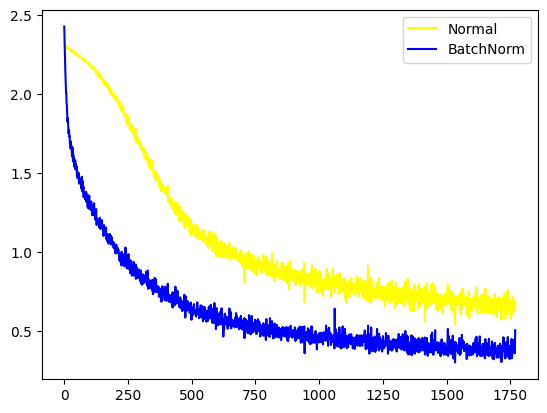

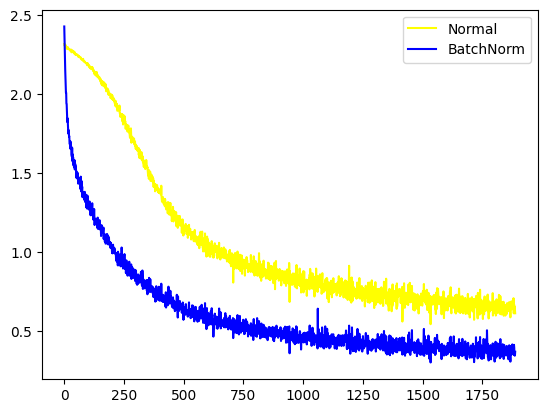

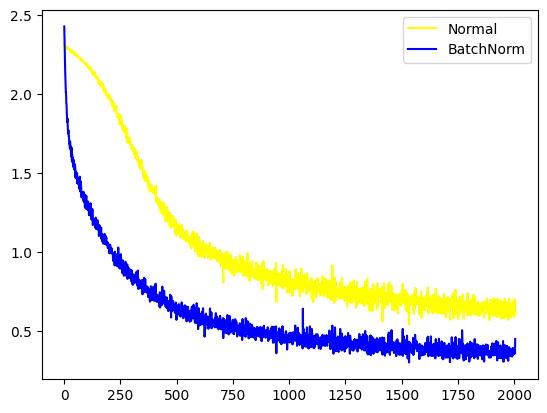

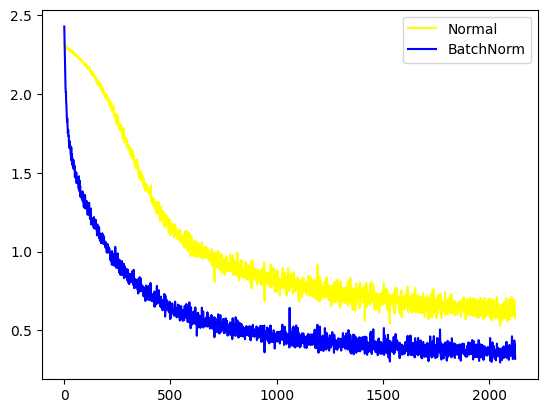

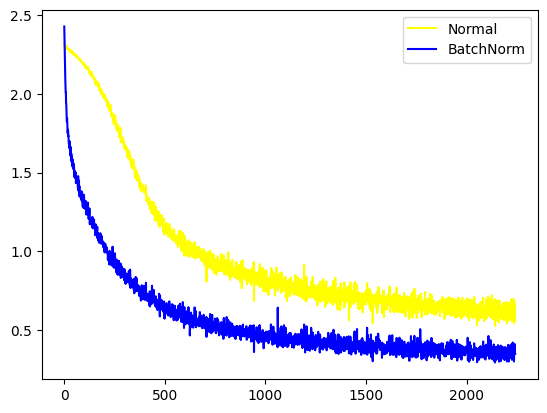

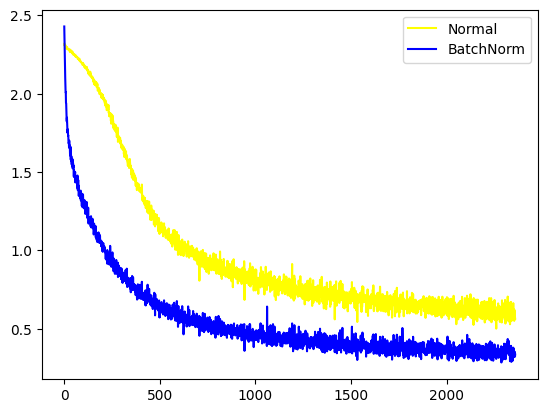

In [ ]:
# 8-14 모델 학습
loss_arr = []
loss_bn_arr = []
max_epochs = 20

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        opt_bn.zero_grad()  # 배치 정규화가 적용된 모델의 학습
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')
    plt.legend()
    plt.show()

In [ ]:
# 8-15 데이터셋의 분포를 출력하기 위한 전처리
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)   # 1
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))  # 2

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

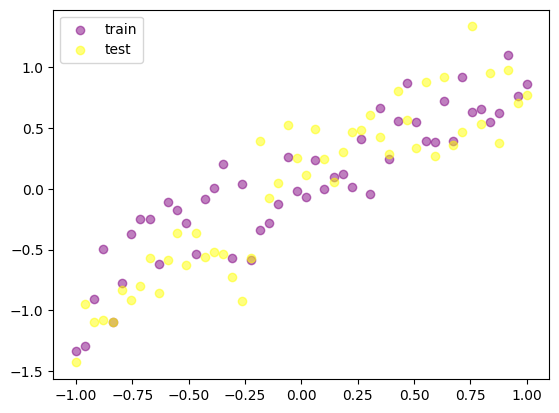

In [ ]:
# 8-16 데이터 분포를 그래프로 출력
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple',
            alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow',
            alpha=0.5, label='test')
plt.legend()
plt.show()

In [ ]:
# 8-17 드롭아웃을 위한 모델 생성
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)  # 드롭아웃 적용되지 않은 모델

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),  # 드롭아웃 적용
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)  # 드롭아웃 적용된 모델

In [ ]:
# 8-18 옵티마이저와 손실 함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

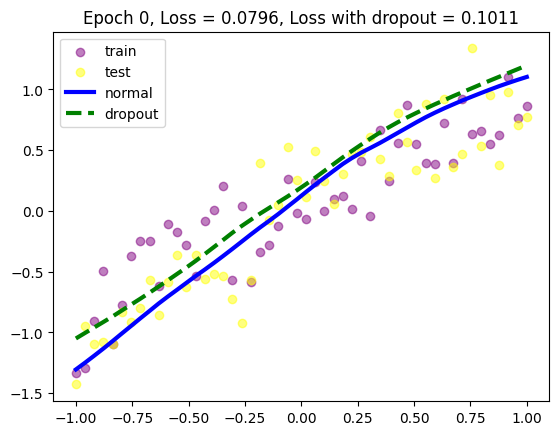

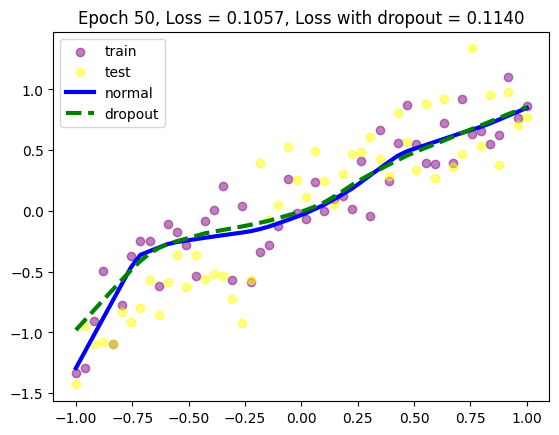

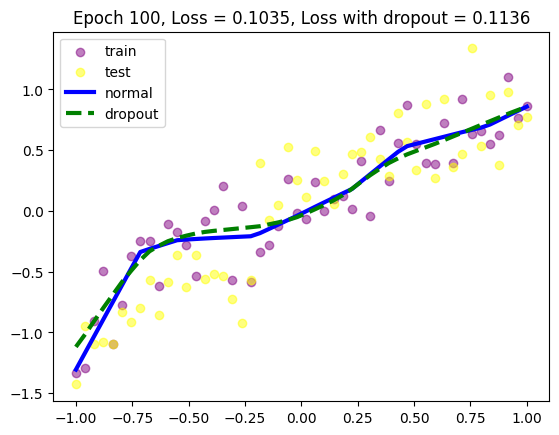

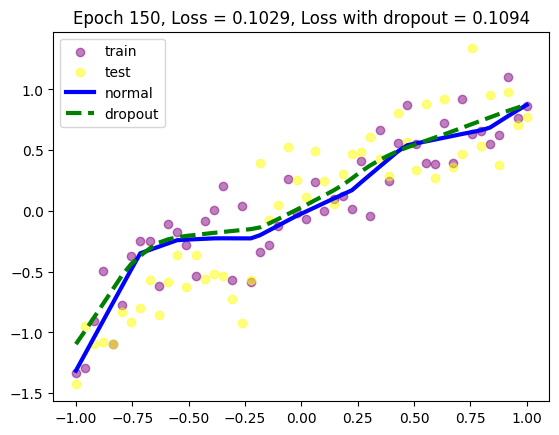

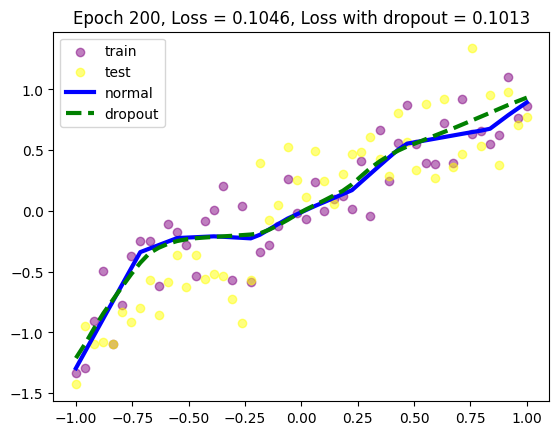

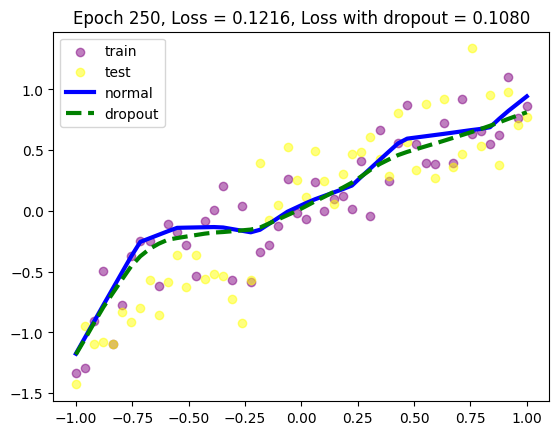

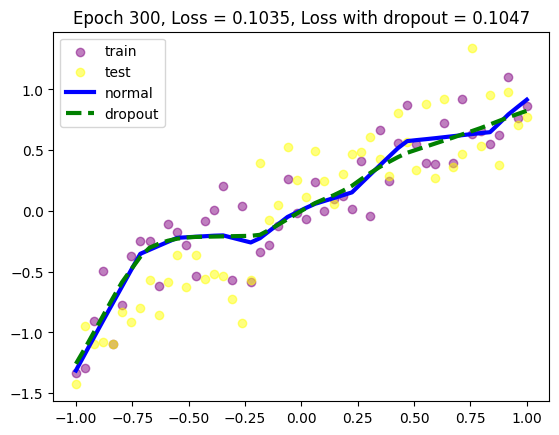

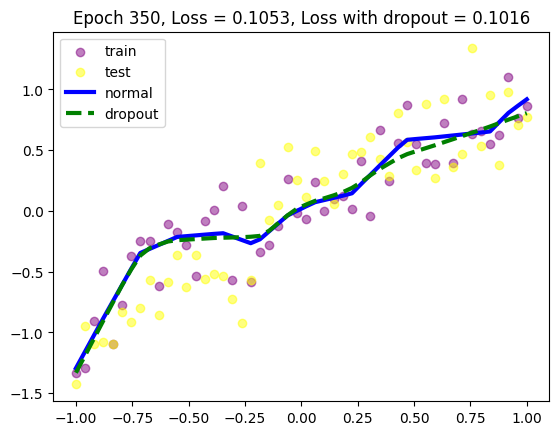

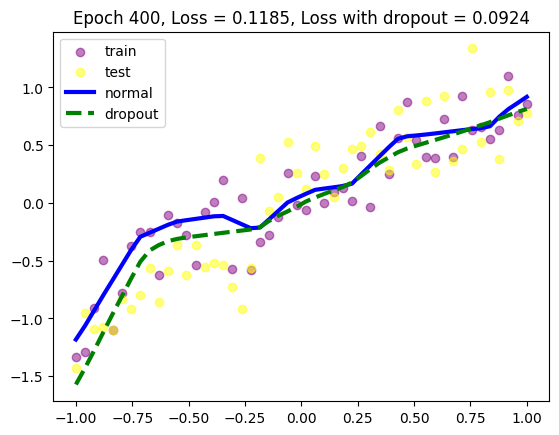

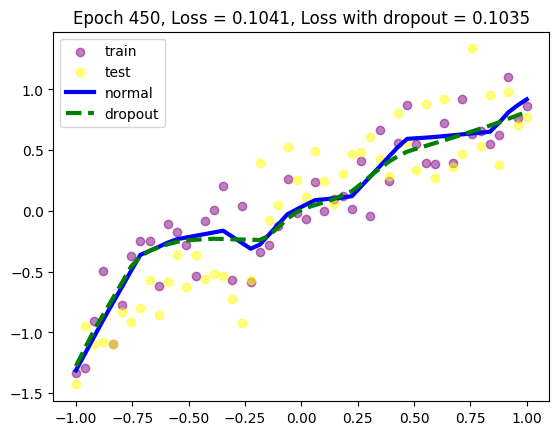

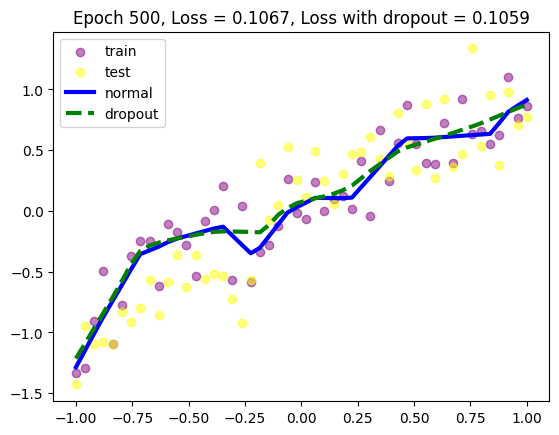

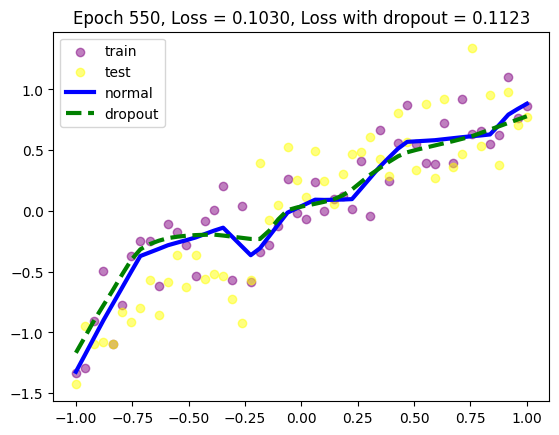

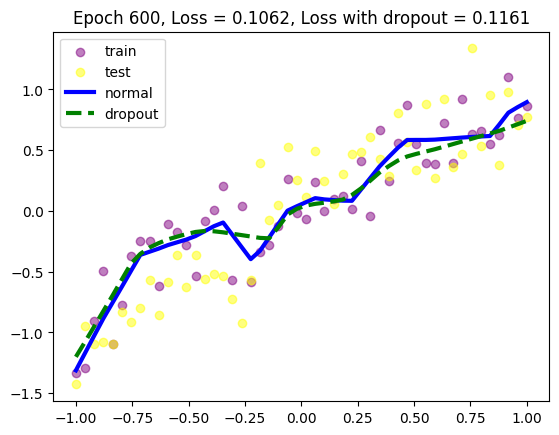

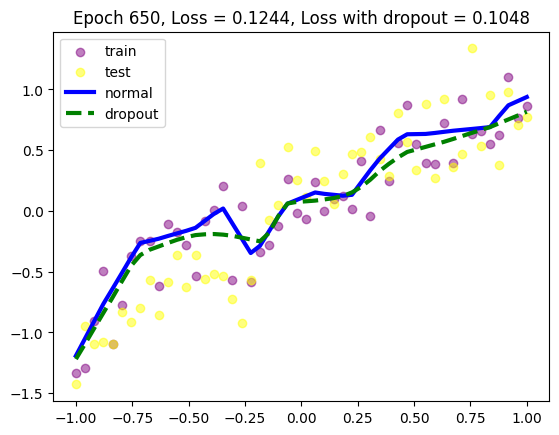

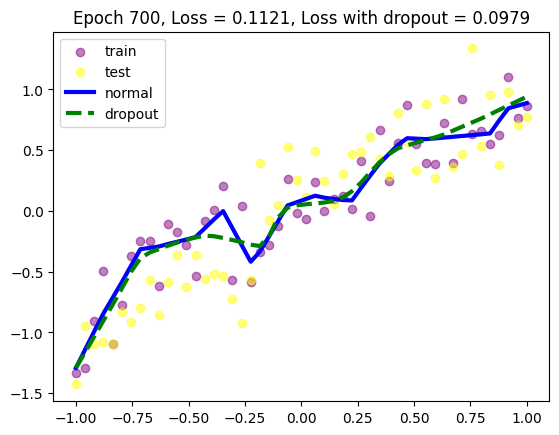

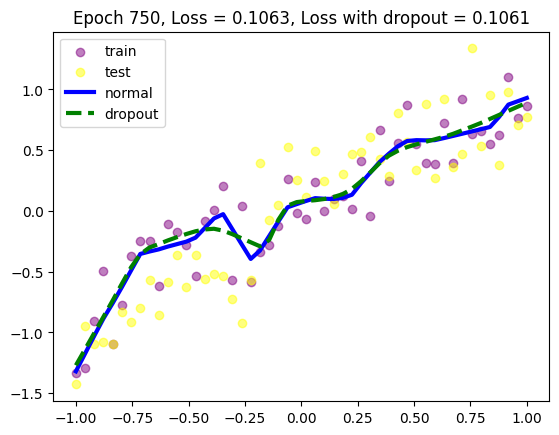

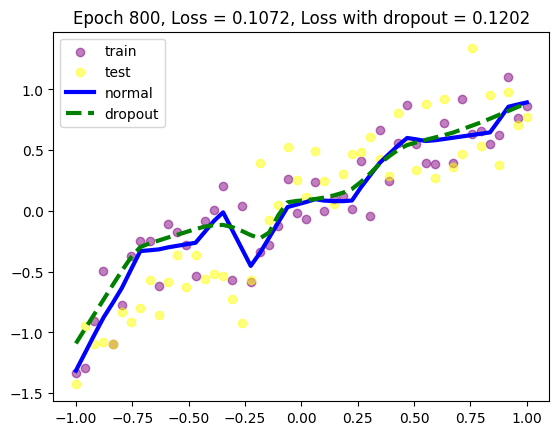

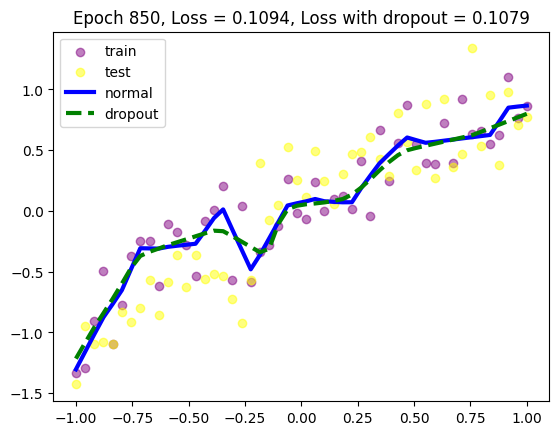

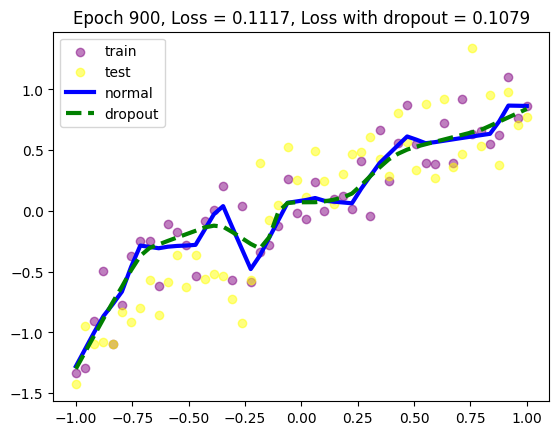

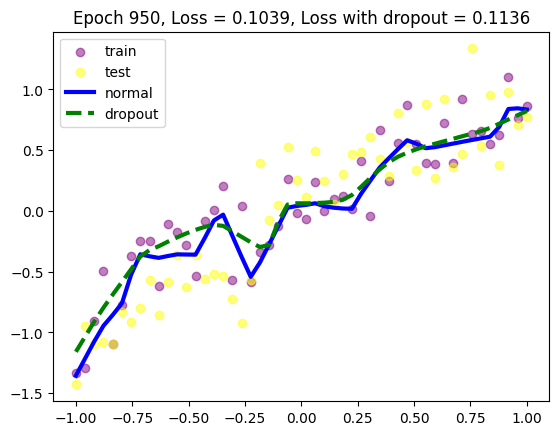

In [ ]:
# 8-19 모델 학습
max_epochs = 1000
for epoch in range(max_epochs):
    pred = model(x_train)  # 드롭아웃 적용되지 않은 모델 학습
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(x_train)  # 드롭아웃 적용된 모델 학습
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0:  # epoch 50으로 나눈 나머지가 0이면 다음 진행
        model.eval()
        model_dropout.eval()

        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)

        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)

        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3, label='dropout')

        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)

### 8.3.3 조기 종료를 이용한 성능 최적화

In [ ]:
# 8-20 라이브러리 호출
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models  # 사전 학습된 모델을 이용하고자 할 때 사용하는 라이브러리
from torchvision import transforms, datasets
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot')  # 출력 그래프에서 격자로 숫자 범위가 눈에 잘 뛰도록 하는 스타일
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 8-21 데이터셋 전처리
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()

Saving archive.zip to archive.zip


In [ ]:
!unzip archive.zip -d archive/

Archive:  archive.zip
   creating: archive/test/
   creating: archive/test/hot_dog/
  inflating: archive/test/hot_dog/133012.jpg  
  inflating: archive/test/hot_dog/133015.jpg  
  inflating: archive/test/hot_dog/133245.jpg  
  inflating: archive/test/hot_dog/135628.jpg  
  inflating: archive/test/hot_dog/138933.jpg  
  inflating: archive/test/hot_dog/138937.jpg  
  inflating: archive/test/hot_dog/138969.jpg  
  inflating: archive/test/hot_dog/139177.jpg  
  inflating: archive/test/hot_dog/142835.jpg  
  inflating: archive/test/hot_dog/143012.jpg  
  inflating: archive/test/hot_dog/144956.jpg  
  inflating: archive/test/hot_dog/146227.jpg  
  inflating: archive/test/hot_dog/146834.jpg  
  inflating: archive/test/hot_dog/147874.jpg  
  inflating: archive/test/hot_dog/152106.jpg  
  inflating: archive/test/hot_dog/154409.jpg  
  inflating: archive/test/hot_dog/154545.jpg  
  inflating: archive/test/hot_dog/156126.jpg  
  inflating: archive/test/hot_dog/156135.jpg  
  inflating: archive/te

In [ ]:
# 8-22 데이터셋 가져오기
train_dataset = datasets.ImageFolder(
    root =r'archive/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r'archive/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [ ]:
# 8-23 모델 생성
def resnet50(pretrained=True, requires_grad=False):
    model = models.resnet50(pretrained=pretrained)
    if requires_grad == False:
        # 파라미터 고정하여 backward() 중에 기울기 계산되지 않도록 함.
        # requires_grad=False 파라미터 받았기 때문에 해당 구문 실행됨.
        for param in model.parameters():
            param.requires_grad =  False
    elif requires_grad == True: # 파라미터 값이 backward() 중에 기울기 계산에 반영됨.
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2)  # 마지막 분류를 위한 계층은 학습 진행함.
    return model

In [ ]:
# 8-24 학습률 감소
class LRScheduler():
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=True
        )  # 1
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)   # 2

In [ ]:
# 8-25 조기 종료
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0,
                 path='checkpoint.pt'):
        self.patience = patience  # 1
        self.verbose = verbose
        self.counter = 0
        self.best_score = None # 검증 데이터셋에 대한 오차 최적화 값(오차 가장 낮은 값)
        self.early_stop = False  # 조기 종료 의미하며 초깃값은 False 설정
        self.val_loss_min = np.Inf  # np.Inf(infinity)는 넘파이에서 무한대 표현
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model): # 에포크만큼 학습 반복되면서 best_loss 갱신되고,
    # best_loss에 진전이 없으면 조기 종료한 후 모델 저장
        score = -val_loss
        if self.best_score is None:  # best_score에 값이 존재하지 않으면 실행
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            # best_score + delta가 score보다 크면 실행
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else: # 그 외 모든 경우에 실행
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model): # 검증 데이터셋에 대한 오차 감소하면 모델 저장
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path) # 저장된 경로에 모델 저장
        self.val_loss_min = val_loss

In [ ]:
# 8-26 인수 값 지정
parser = argparse.ArgumentParser()  # 인수 값 받을 수 있는 인스턴스 생성
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true') # 1
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
# 조기 종료에 대한 변수
# Simulate command-line arguments
# for example, to enable both lr-scheduler and early-stopping
args = vars(parser.parse_args(['--lr-scheduler', '--early-stopping']))  # 2

In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.2 MB/s eta 0:00:00


In [ ]:
# 8-27 사전 훈련된 모델의 파라미터 확인
print(f'Computation device: {device}\n')  # CPU 사용하는지 GPU 사용하는지 검사
model = models.resnet50(pretrained=True).to(device)  # 사전 훈련된 ResNet50 사용
total_params = sum(p.numel() for p in model.parameters()) # 총 파라미터 수
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)  # 학습 가능한 파라미터 수
print(f"{total_trainable_params:,} training parameters.")

Computation device: cuda:0



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


25,557,032 total parameters.
25,557,032 training parameters.


In [ ]:
# 8-28 옵티마이저와 손실 함수 지정
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 8-29 오차, 정확도 및 모델의 이름에 대한 문자열
loss_plot_name = 'loss'  # 오차 출력에 대한 문자열
acc_plot_name = 'accuracy'  # 정확도 출력에 대한 문자열
model_name = 'model'  # 모델을 저장하기 위한 문자열

In [ ]:
# 8-30 오차, 정확도 및 모델의 이름에 대한 문자열
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss'  # 학습률 감소를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'lrs_accuracy' # 학습률 감소를 적용했을 때의 정확도에 대한 문자열
    model_name = 'lrs_model'  # 학습률 감소를 적용했을 때의 모델에 대한 문자열
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'  # 조기 종료 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'es_accuracy'  # 조기 종료 적용했을 때의 정확도에 대한 문자열
    model_name = 'es_model'  # 조기 종료 적용했을 때의 모델에 대한 문자열

INFO: Initializing learning rate scheduler
INFO: Initializing early stopping


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# 8-31 모델 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100. * (train_running_correct) / total
    return train_loss, train_accuracy

In [ ]:
# 8-32 모델 검증 함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    # 모델 검증 과정 시각적으로 표현
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * (val_running_correct) / total
        return val_loss, val_accuracy

In [ ]:
# 8-33 모델 학습
train_loss, train_accuracy = [], []
# 훈련 데이터셋을 이용한 모델 학습 결과(오차, 정확도)를 저장하기 위한 변수(리스트 형태)

val_loss, val_accuracy = [], []
# 검증 데이터셋을 이용한 모델 학습 결과(오차, 정확도)를 저장하기 위한 변수(리스트 형태)

start = time.time()
for epoch in range(epochs):
    print(f'Epoch {epoch+1} of {epochs}')
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:  # 인수 값이 lr_scheduler이면 다음 실행
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:  # 인수 값이 early_stopping이면 다음 실행
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training


16it [00:10,  1.50it/s]


Validating


16it [00:03,  4.17it/s]


Train Loss: 2.3071, Train Acc: 59.04
Val Loss: 229.5166, Val Acc: 4.80
Epoch 2 of 100
Training


16it [00:04,  3.37it/s]


Validating


16it [00:03,  4.80it/s]


Train Loss: 0.5599, Train Acc: 70.28
Val Loss: 0.7058, Val Acc: 65.20
Epoch 3 of 100
Training


16it [00:04,  3.61it/s]


Validating


16it [00:04,  3.98it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.4679, Train Acc: 79.52
Val Loss: 0.8123, Val Acc: 64.60
Epoch 4 of 100
Training


16it [00:04,  3.59it/s]


Validating


16it [00:03,  4.80it/s]


Train Loss: 0.3909, Train Acc: 80.52
Val Loss: 0.5761, Val Acc: 74.20
Epoch 5 of 100
Training


16it [00:04,  3.41it/s]


Validating


16it [00:03,  4.80it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.3048, Train Acc: 87.75
Val Loss: 0.6847, Val Acc: 75.80
Epoch 6 of 100
Training


16it [00:04,  3.60it/s]


Validating


16it [00:03,  4.10it/s]


EarlyStopping counter: 2 out of 5
Train Loss: 0.3270, Train Acc: 87.15
Val Loss: 0.9559, Val Acc: 72.60
Epoch 7 of 100
Training


16it [00:04,  3.54it/s]


Validating


16it [00:03,  4.69it/s]


EarlyStopping counter: 3 out of 5
Train Loss: 0.2478, Train Acc: 90.96
Val Loss: 0.7167, Val Acc: 69.00
Epoch 8 of 100
Training


16it [00:04,  3.39it/s]


Validating


16it [00:03,  4.73it/s]


EarlyStopping counter: 4 out of 5
Train Loss: 0.2597, Train Acc: 90.96
Val Loss: 0.6080, Val Acc: 79.40
Epoch 9 of 100
Training


16it [00:04,  3.56it/s]


Validating


16it [00:03,  4.26it/s]

EarlyStopping counter: 5 out of 5
Training time: 1.339 minutes


Saving loss and accuracy plots...


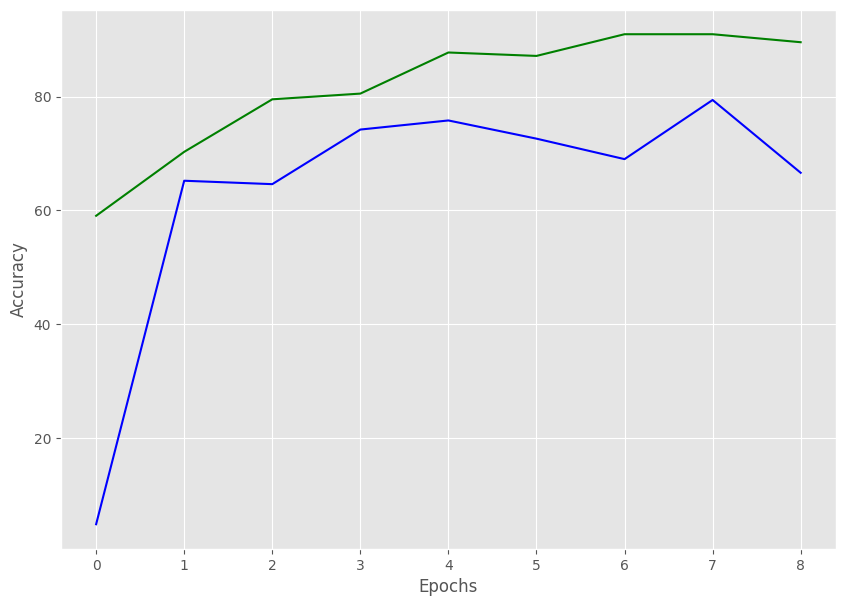

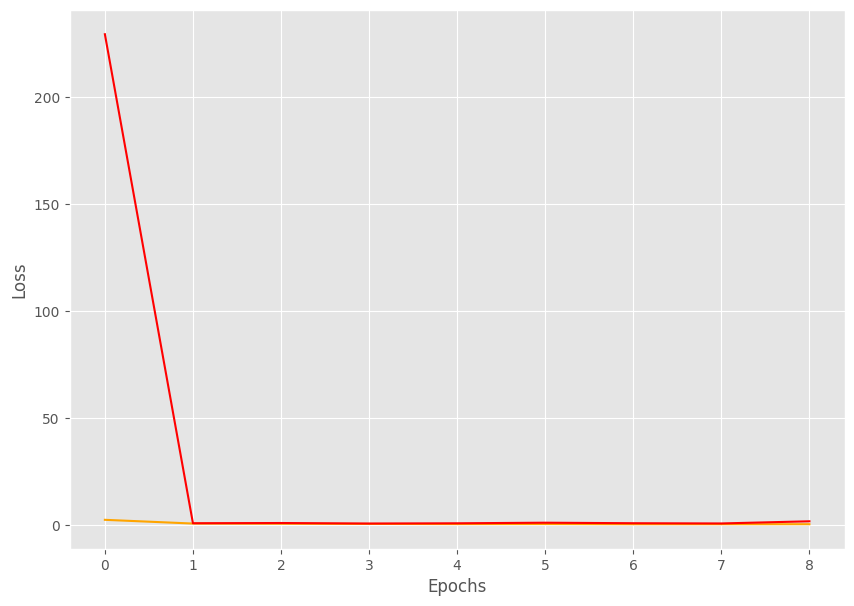

Saving model...
TRAINING COMPLETE


In [ ]:
# 8-34 모델 학습 결과 출력
print('Saving loss and accuracy plots...')
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
# 훈련 데이터셋에 대한 정확도를 그래프로 출력
plt.plot(val_accuracy, color='blue', label='validation accuracy')
# 검증 데이터셋에 대한 정확도를 그래프로 출력
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(f"{acc_plot_name}.png")
plt.show()
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train loss')
# 훈련 데이터셋에 대한 오차를 그래프로 출력
plt.plot(val_loss, color='red', label='validation loss')
# 검증 데이터셋에 대한 오차를 그래프로 출력
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f"{loss_plot_name}.png")
plt.show()

print('Saving model...')
torch.save(model.state_dict(), f"{model_name}.pth") # 모델 저장
print('TRAINING COMPLETE')